# Data Augmentation

Here we will look to generate augmented data for the fine-tuning process. Here is a list of image alterations we will make before augmentation:

1. Blur (BLUR)
2. Contrast (CONTp, CONTn)
3. Brightness (BRIGHTp, BRIGHTn)
4. Saturation (SATp, SATn)
5. Zoom (ZOOMp, ZOOMn)
6. Unchanged (U)

The abbreviation in parenthesis will advise both the variable naming in this notebook and image file naming. The p/n denotes positive and negative respectively (and in/out for zoom). We will also be using every combination of two of above altered images as well. E.g. BLUR:CONTp that will be blurred and have increased contrast.

Note that the fine-tuning process will also involve the unaltered blood smear images to train the model what a smear 'should' look like.

### Random Sampling of Images for Alteration

We will use the OpenCV (cv2) python package to manually alter images. For each of our four classes we will alter 100 images for a total of 400 per category (blur/tint/contrast/etc.). These 400 images will then be fed to tensorflow data augmentation to generate all images that will be used during the fine-tuning process.

This assumes that you had downloaded the blood smear images into the following data directory:

* ./Data
* ./Data/Benign
* ./Data/Early
* ./Data/Pre
* ./Data/Pro

Here we will choose 100 random images from each blood smear class for each alteration category. We will choose 100x5 (500) unchanged images to give the model a really clear idea of what an unaltered benign blood smear looks like.

The seed is set to ensure transparency and reproducability.

In [1]:
import random
from itertools import combinations

n_images = 100
alt_classes = { #alteration classes and their associated captions
    'BLUR': 'increase image resolution', 
    'CONTp': 'decrease contrast', 
    'CONTn': 'increase contrast', 
    'BRIGHTp': 'decrease brightness', 
    'BRIGHTn': 'increase brightness', 
    'SATp': 'decrease saturation', 
    'SATn': 'increase saturation', 
    'ZOOMp': 'zoom in', 
    'ZOOMn': 'zoom out'
}
alteration_classes = {}

for key in alt_classes:
    alteration_classes[key] = alt_classes[key]
for r in range(2, 3):
    for combo in combinations(alt_classes, r):
        alteration_classes[':'.join(combo)] = alt_classes[combo[0]] + ' and ' + alt_classes[combo[1]]
alteration_classes['U'] = ''
    
image_cat_dict = { #There are 504 benign, 985 early, 963 pre and 804 pro images. 
    'Benign': 504,
    'Early': 985,
    'Pre': 963,
    'Pro': 804
}

alt_images_dict = {} #hold all the images randomly chosen for each class/category

random.seed(234234059)
for key in image_cat_dict:
    category = key
    lower_bound = 1 
    upper_bound = image_cat_dict[category]
    
    if key == 'Benign':
        img_path_substring = 'WBC-'
    else:
        img_path_substring = 'WBC-Malignant-'
    
    for key in alteration_classes:
        inner_key = key
        s =  category + '_' + inner_key
        
        if inner_key == 'U':
            random_numbers = sorted(random.sample(range(lower_bound, upper_bound + 1), n_images*5))
        else:
            random_numbers = sorted(random.sample(range(lower_bound, upper_bound + 1), n_images))
            
        file_dir = ['./Data/' + category + '/' + img_path_substring + category + '-{:03d}.jpg'.format(num) 
                    for num in random_numbers]
        
        alt_images_dict[s] = file_dir

#first 10 images randomly chosen from the benign class for negative saturation
print(alt_images_dict['Benign_SATn'][:10])

['./Data/Benign/WBC-Benign-009.jpg', './Data/Benign/WBC-Benign-011.jpg', './Data/Benign/WBC-Benign-021.jpg', './Data/Benign/WBC-Benign-022.jpg', './Data/Benign/WBC-Benign-031.jpg', './Data/Benign/WBC-Benign-034.jpg', './Data/Benign/WBC-Benign-035.jpg', './Data/Benign/WBC-Benign-036.jpg', './Data/Benign/WBC-Benign-039.jpg', './Data/Benign/WBC-Benign-040.jpg']


Next, let's create a staging folder directory to house the images we'll pass onto data augmentation. This folder directory will look like:

* ./Staging
* ./Staging/Benign/BLUR
* ./Staging/Benign/CONTRASTp
* etc.

In [2]:
import os
import shutil

def create_data_dir(root_name):
    for key in image_cat_dict:
        for alt_class in alteration_classes:
            folder_dir = './' + root_name + '/' + key + '/' + alt_class

            if os.path.exists(folder_dir):
                pass
            else:
                os.makedirs(folder_dir)

def reset_data_dir(root_name):
    directory_to_clear = './' + root_name

    for root, dirs, files in os.walk(directory_to_clear, topdown=False):
        for file in files:
            file_path = os.path.join(root, file)
            os.remove(file_path)
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            shutil.rmtree(dir_path)
    
    create_data_dir(root_name)

### Image Alteration

Now that we have which images we'll be altering and the directories where the altered images will be saved, lets use the cv2 package to mess these images up.

Note that there will be no alterations to any of the 'U' class so those will be excluded here.

All of these numbers will be stored in a python dictionary.

In [3]:
#!pip install opencv-python
import cv2
import numpy as np
from IPython.display import display
from PIL import Image

#custom method to display cv2 image
def display_image(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image_rgb)
    display(pil_image)

We'll also look to apply some level of randomness to our alteration effects. This is done to ensure we're not just blank applying the exact same tranformations to each image in each category so the model can learn to identify a wider range of effects.

#### Blur
Starting off with blur we will use the function: cv2.GaussianBlur(image, (11, 11), 0)

* (11, 11) denotes a 11x11 kernel used for blurring (kernels must be odd integers). Larger kernels increase the blur effect.
* 0 denotes 'sigma', or the standard deviation for the Gaussian Kernel. This will remain constant at 0 to allow the kernel to determine the blurring.

We will apply random kernel sizes from [5, 15].

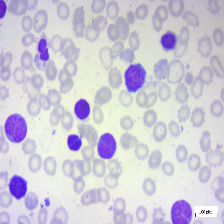

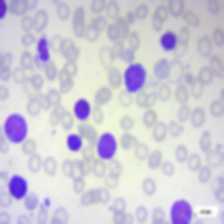

In [4]:
image = cv2.imread(alt_images_dict['Benign_BLUR'][0])
display_image(image)

blurred_image = cv2.GaussianBlur(image, (7, 7), 0)
display_image(blurred_image)

#### Contrast

For contrast we will use the function: cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

* alpha controls contrast with values less than 1 decreasing contrast and greater than 1 increasing contrast
* beta controls brightness with 0 being no change, for changing contrast we will leave beta at 0

We will apply random alpha values from [.1, .4] for negative and [1.2, 2] for positive

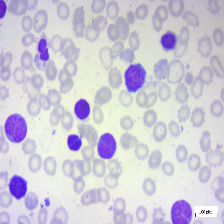

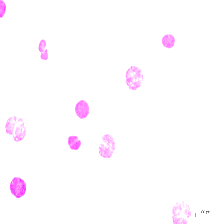

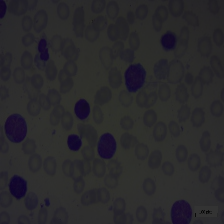

In [15]:
contrast_increase_image = cv2.convertScaleAbs(image, alpha=3, beta=0)
contrast_decrease_image = cv2.convertScaleAbs(image, alpha=0.2, beta=0)

display_image(image)
display_image(contrast_increase_image)
display_image(contrast_decrease_image)

#### Brightness

For brightness we will again use the function: cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

* alpha controls contrast with 0 being no change, for changing brightness we will leave beta at 0
* beta controls brightness with with values less than 0 decreasing contrast and greater than 0 increasing contrast

We will apply random alpha values from [-150, -110] for negative and [45, 75] for positive

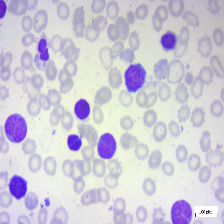

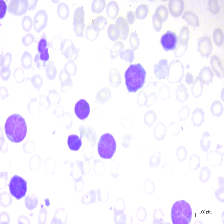

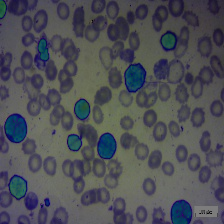

In [6]:
brightness_increase_image = cv2.convertScaleAbs(image, alpha=1, beta=50)
brightness_decrease_image = cv2.convertScaleAbs(image, alpha=1, beta=-130)

display_image(image)
display_image(brightness_increase_image)
display_image(brightness_decrease_image)

#### Saturation

For saturation we will have to jump through a couple of hoops.

1. Convert image from BGR to HSV color space
2. Adjust the saturation channel with a saturation factor, saturation greater than 1 increases it and less than 1 decreases it
3. Convert image back to BGR from HSV color space

We will apply random saturation values from [0.1, 0.3] for negative and [1.7, 1.9] for positive

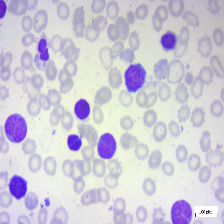

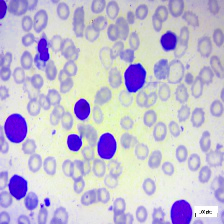

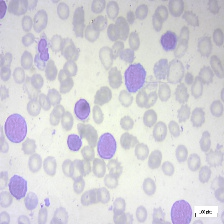

In [10]:
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

saturation_factor = 1.99
hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1] * saturation_factor, 0, 255).astype(np.uint8)
saturation_increase_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

saturation_factor = 0.3
hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1] * saturation_factor, 0, 255).astype(np.uint8)
saturation_decrease_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

display_image(image)
display_image(saturation_increase_image)
display_image(saturation_decrease_image)

#### Zoom

For zoom we can use cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR) where width and height as multiplied by a scaling factor. If that factor is less than one it has the effect of zooming out, if the factor is greater than one it has the effect of zooming in.


We will apply random saturation values from [.4, .8] for negative (zoom in) and [1.2, 1.6] for positive (zoom out)

In [ ]:
scale_percent = 1.5
width = int(image.shape[1] * scale_percent)
height = int(image.shape[0] * scale_percent)
zoom_in_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)

scale_percent = 0.5
width = int(image.shape[1] * scale_percent)
height = int(image.shape[0] * scale_percent)
zoom_out_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)

display_image(image)
display_image(zoom_in_image)
display_image(zoom_out_image)

With what we learned during the exploration into image alteration above we're going to programmatically alter our base smear images. To help do so the following code creates a dictionary with each key being a unique image and the alterations applied to it. Each alteration will also draw parameters randomly to ensure there's more variation in this dataset than if we blindly applied the same changes to all images in the same category.

In [ ]:
def gen_img_values():
    alt_image_values_dict = {}

    random.seed(234234059)
    for key in alt_images_dict:
        outer_key = key
        inner_args = {}

        if 'BLUR' in key:
            inner_args['BLUR'] = [5, 15 + 1, 2] #correspond to lower_bound, upper_bound, step
        if 'CONTp' in key:
            inner_args['CONTp'] = [1.2, 2, .1]
        if 'CONTn' in key:
            inner_args['CONTn'] = [.1, .4, .1]
        if 'BRIGHTp' in key:
            inner_args['BRIGHTp'] = [45, 75, 1]
        if 'BRIGHTn' in key:
            inner_args['BRIGHTn'] = [-150, -110, 1]
        if 'SATp' in key:
            inner_args['SATp'] = [1.7, 1.9, .1]
        if 'SATn' in key:
            inner_args['SATn'] = [.1, .3, .1]
        if 'ZOOMp' in key:
            inner_args['ZOOMp'] = [1.2, 1.6, .1]
        if 'ZOOMn' in key:
            inner_args['ZOOMn'] = [.4, .8, .1]
        else:
            pass

        for image_path in alt_images_dict[key]:
            s = str(outer_key) + '_' + image_path[image_path.rfind('/') + 1:image_path.find('.jpg')]

            inner_dict = {}
            inner_dict['orig_path'] = image_path

            if ':' in outer_key:
                category = outer_key[0:outer_key.find('_')]
                alt_class = s[s.find('_') + 1:s.rfind('_')]
                staging_path = './Staging/' + category + '/' + alt_class
                caption = 'Blood smear: ' + alt_classes[alt_class[0:alt_class.find(':')]] + ' and ' + alt_classes[alt_class[alt_class.find(':') + 1:]]
            else:
                category = outer_key[0:outer_key.find('_')]
                alt_class = outer_key[outer_key.rfind('_') + 1:]
                staging_path = './Staging/' + category + '/' + alt_class
                if '_U' in outer_key:
                    caption = 'Blood smear: '
                else:
                    caption = 'Blood smear: ' + alt_classes[alt_class]

            if not os.path.exists(staging_path):
                raise RuntimeError("Path " + staging_path + " doesn't exist")
            else:
                img_name = image_path[image_path.find('WBC'):]
                stag_path = staging_path + '/Stag-' + img_name
                inner_dict['staging_path'] = stag_path
                inner_dict['ft_path'] = stag_path.replace('Staging', 'Finetuning')

                for key in inner_args:
                    random_num = round(np.random.choice(np.arange(inner_args[key][0], inner_args[key][1], inner_args[key][2])), 2)
                    inner_dict[key] = random_num

                inner_dict['caption'] = caption

                alt_image_values_dict[s] = inner_dict
                
    return alt_image_values_dict
        
alt_image_values_dict = gen_img_values()
alt_image_values_dict['Benign_BLUR:CONTp_WBC-Benign-497']

In [ ]:
#Let's try programatically creating all the altered images in alt_image_values_dict and putting them into Staging
#This method takes a minute to run as it's creating thousands of images
def populate_staging():
    reset_data_dir('Staging')

    for key in alt_image_values_dict:
        image = cv2.imread(alt_image_values_dict[key]['orig_path'])
        
        if 'BLUR' in key:
            image = cv2.GaussianBlur(image, (alt_image_values_dict[key]['BLUR'], alt_image_values_dict[key]['BLUR']), 0)
        if 'CONTp' in key:
            image = cv2.convertScaleAbs(image, alpha=alt_image_values_dict[key]['CONTp'], beta=0)
        if 'CONTn' in key:
            image = cv2.convertScaleAbs(image, alpha=alt_image_values_dict[key]['CONTn'], beta=0)
        if 'BRIGHTp' in key:
            image = cv2.convertScaleAbs(image, alpha=1, beta=alt_image_values_dict[key]['BRIGHTp'])
        if 'BRIGHTn' in key:
            image = cv2.convertScaleAbs(image, alpha=1, beta=alt_image_values_dict[key]['BRIGHTn'])
        if 'SATp' in key:
            hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            saturation_factor = alt_image_values_dict[key]['SATp']
            hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1] * saturation_factor, 0, 255).astype(np.uint8)
            image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
        if 'SATn' in key:
            hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            saturation_factor = alt_image_values_dict[key]['SATn']
            hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1] * saturation_factor, 0, 255).astype(np.uint8)
            image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
        if 'ZOOMp' in key:
            image = cv2.resize(image, 
                               (int(image.shape[0] * alt_image_values_dict[key]['ZOOMp']), 
                                int(image.shape[1] * alt_image_values_dict[key]['ZOOMp'])), 
                               interpolation=cv2.INTER_LINEAR)
        if 'ZOOMn' in key:
            image = cv2.resize(image, 
                               (int(image.shape[0] * alt_image_values_dict[key]['ZOOMn']), 
                                int(image.shape[1] * alt_image_values_dict[key]['ZOOMn'])), 
                               interpolation=cv2.INTER_LINEAR)
        
        cv2.imwrite(alt_image_values_dict[key]['staging_path'], image)
        
populate_staging()

### Data Augmentation

Now that we have our altered images in Staging, it's time to use TensorFlow data augmentation to create more images to fine-tune our caption generation model.

**THIS MAY NOT BE NECESSARY, ALREADY HAVE 20K IMAGES**

In [ ]:
'''import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
import matplotlib.pyplot as plt'''

In [ ]:
'''Generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=10,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

for key in alt_image_values_dict:
    if 'U_' in key:
        pass
    else:
        continue
    
    img = load_img(alt_image_values_dict[key]['staging_path'])
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    # Generate augmented images
    i = 0
    for batch in Generator.flow(x, batch_size=1):
        plt.figure(i)
        imgplot = plt.imshow(array_to_img(batch[0]))
        i += 1
        if i % 2 == 0:  # Display four augmented images
            break

    plt.show()
    break'''

In [ ]:
'''#This takes a few minutes to run as it's creating tens of thousands of images
reset_data_dir('Finetuning')

def populate_finetuning():
    reset_data_dir('Finetuning')

    for key in alt_image_values_dict:
        i = 0

        img = load_img(alt_image_values_dict[key]['staging_path'])
        img.save(alt_image_values_dict[key]['ft_path'].replace('.jpg', '_' + str(i) + '.jpeg'))

        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)
        for batch in Generator.flow(x, batch_size=1):
            augmented_img = array_to_img(batch[0])
            img_filename = f'augmented_image_{i}.jpg'
            augmented_img.save(alt_image_values_dict[key]['ft_path'].replace('.jpg', '_' + str(i) + '.jpeg'))
            i += 1
            if i % 4 == 0:  # Save four augmented images
                break

#populate_finetuning()'''

## Finetuning

Now we have our altered images and their associated captions and are ready to fine-tune the model. For the sake of this notebook we will only conduct a small scale tuning process involving a few images from each alteration class. The real training with tens of thousands of images will be done via CLI.

In [ ]:
import pandas as pd

images_dict = gen_img_values()

images = []
text_labels = []

for key in alt_images_dict:
    outer_key = key
    n = 0 #we will use all images for actual training
    
    for key in images_dict:
        inner_key = key
        
        if outer_key in inner_key:
            images.append(Image.open(images_dict[inner_key]['staging_path']))
            text_labels.append(images_dict[inner_key]['caption'])
            n+=1
            
        else:
            pass

        if n>5:
            break
    
ds = pd.DataFrame({'image': images, 'text': text_labels})
ds[:10]

Sample image/text pair

In [ ]:
display(ds.loc[0]['image'])
print(ds.loc[0]['text'])

### Pre-process Data

Resize and pixel scale the image as well as tokenize captions

In [ ]:
import torch
from transformers import AutoProcessor
from torchvision import transforms
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split

processor = AutoProcessor.from_pretrained("microsoft/git-base")

class ProcessDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.dataframe = dataframe
        self.processor = processor
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = row['text']
        image = row['image']

        # Preprocess text using the processor
        text_encoding = self.processor(
            text,
            return_tensors="pt",
            padding="max_length",
            max_length=512,
            truncation=True
        )
        
        image = self.transform(image)
        
        return {
            'input_ids': text_encoding['input_ids'].squeeze(),
            'attention_mask': text_encoding['attention_mask'].squeeze(),
            'pixel_values': image.permute(0, 2, 1)
        }

train_ds, test_ds = train_test_split(ds, test_size=.1)
train_dataset = ProcessDataset(train_ds, processor)
test_dataset = ProcessDataset(test_ds, processor)

Check dimensions

In [ ]:
for k,v in train_dataset[0].items():
  print(k,v.shape)

In [ ]:
print(vars(test_dataset))

### PyTorch DataLoader

Batches of data from traininset to be send into the model (so it doesn't get overloaded looking at everything at once).

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=4)
validation_dataloader = DataLoader(test_dataset, batch_size=4)

batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

In [ ]:
processor.decode(batch["input_ids"][0])

### Pre-trained Model

In [ ]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

Dummy pass to verify it works and check initial loss

In [ ]:
#Dummy pass on our batch to check initial loss
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

### Training

In [ ]:
from jiwer import wer

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

# Training loop
num_epochs = 1  # Adjust as needed
for epoch in range(num_epochs):
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)
        attention_mask = batch.pop("attention_mask").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        attention_mask=attention_mask,
                        labels=input_ids)

        loss = outputs.loss

        #print(f"Epoch {epoch+1}, Batch {idx+1}, Loss: {loss.item()}")

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

    # Validation loop
    model.eval()
    total_wer_score = 0.0
    with torch.no_grad():
        for batch in validation_dataloader:
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)
            attention_mask = batch.pop("attention_mask").to(device)
            labels = input_ids  # Using input_ids as labels

            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            attention_mask=attention_mask,
                            labels=labels)

            predicted = outputs.logits.argmax(-1)
            decoded_labels = processor.batch_decode(labels.cpu().numpy(), skip_special_tokens=True)
            decoded_predictions = processor.batch_decode(predicted.cpu().numpy(), skip_special_tokens=True)
            
            wer_score = wer(decoded_labels, decoded_predictions)
            total_wer_score += wer_score

    average_wer_score = total_wer_score / len(validation_dataloader)
    print(f"WER Score after Epoch {epoch+1}: {average_wer_score}")

    model.train()

### Sanity Check

In [ ]:
image = Image.open('./Staging/Benign/BLUR/Stag-WBC-Benign-276.jpg')
display(image)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)